<div align="justify">
  <h1> Modelagem do Sistema Cardiovascular Humano - ECOM168 </h1>
  <h2><b> Projeto Final </b></h2>
  <h3> Prof. Thiago Cordeiro</h3>
  <h4><b>Alunos</b></h4>

  <b><i>Ruan Heleno Correa da Silva - 18112344</i></b>

  <b><i>Derek Nielsen Araújo Alves - 17212092 </i></b>

  <b><i>João Pedro Brito Tomé - 18112204</i></b>

  <b><i>John Davi Dutra Canuto Pires - 18112206</i></b>

  <b><i>Matheus Ferreira Gêda - 18112339</i></b>

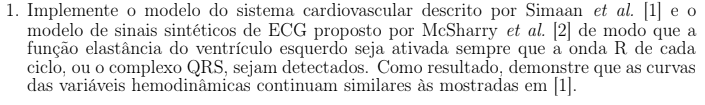

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def ECG_Plot(t, E, ECG):

  fig, ax1 = plt.subplots(figsize=(20, 6), facecolor='silver')
  ax1.set_xlabel('Tempo (s)')
  ax1.set_ylabel('E(t) mmHg/ml', c ='red')
  ax1.plot(t ,E, c = 'black', lw = 2, label ='E(t)')
  ax1.legend(loc='upper left')
  ax1.tick_params(axis='y', labelcolor ='red')

  ax2 = ax1.twinx()
  ax2.set_ylabel('Voltage (mV)', c ='black') 
  ax2.plot(t, ECG, c = 'red', lw = 2, label ='ECG')
  ax2.legend()
  ax2.tick_params(axis='y', labelcolor ='black')
  fig.tight_layout()
  plt.vlines([x*0.5 + 0.25 for x in range(0, 8)], ymin=-0.01, ymax=0.02, linestyles = 'dashed')
  plt.legend()
  plt.show()

# Double hill function proposta por Simaan, adaptada para ativar quando detectar onda R.

In [ ]:
#t, intervalos de tempo
#HR, heart rate
#k, ponto onde a função de elastância se inicia

def elastance(t, passo, HR, k):
    #Double hill function
    tc = 60/HR
    t_max = 0.2 + 0.15 * tc
    tn = []
    En = []

    for i in range(int(tc/passo)):
        if i + k == len(t): 
            break
        _t = t[i] % tc # repetimos o ciclo cardíaco
        tn.append(_t/t_max)
        t1 = (tn[-1] / 0.7) ** 1.9
        t2 = 1 + t1
        t3 = 1 + (tn[-1]/1.17) ** 21.9
        En.append(1.55 * (t1/t2) * (1/t3))
        
    return En, int((tc/passo) + k)

In [ ]:
def ECG_Gen(t, HR):

    passo = t[1] - t[0]
    N = len(t)
    #Alocando arrays
    x = np.empty(N)
    y = np.empty(N)
    z = np.empty(N)
    theta_i = np.empty(5)
    a_i = np.empty(5)
    b_i = np.empty(5)

    # Condições iniciais ECG
    sum = 0
    tc = 60/HR
    x[0] = -1
    y[0] = 0
    z[0] = 0
    
    #P
    theta_i[0] = (-1/3)*np.pi
    a_i[0] = 1.2
    b_i[0] = 0.25
    #Q
    theta_i[1] = (-1/12)*np.pi
    a_i[1] = -5.0
    b_i[1] = 0.1
    #R
    theta_i[2] = 0
    a_i[2] = 30.0
    b_i[2] = 0.1
    #S
    theta_i[3] = (1/12)*np.pi
    a_i[3] = -7.5
    b_i[3] = 0.1
    #T
    theta_i[4] = (1/2)*np.pi
    a_i[4] = 0.75
    b_i[4] = 0.4


    #Valores para elastância Simaan
    En = []
    EnAux = []
    delK = 0 
    RCounter = 0

    for i in range(N-1):
        alpha = 1.0 - np.sqrt(x[i] ** 2 + y[i] ** 2)
        omega = 2 * np.pi/tc
        x[i+1] = passo * (alpha * x[i] - omega * y[i]) + x[i]
        y[i+1] = passo * (alpha * y[i] + omega * x[i]) + y[i]
        theta = np.arctan2(y[i], x[i])
        
        sum = 0
        for j in range(5):
            delTheta = (theta - theta_i[j]) 
            sum += a_i[j] * delTheta * np.exp(-(delTheta ** 2)/(2 * (b_i[j] **2)))
        
        z[i+1] = passo * (-sum - z[i]) + z[i]

        # inserção da função elastância
        if(z[i+1] >= 0.02 and RCounter <= t[i]//tc):
            _En, delK = elastance(t, passo, HR, i)
            En += _En
            RCounter += 1  
        elif delK <= i:
            En.append(0)

    return z, En

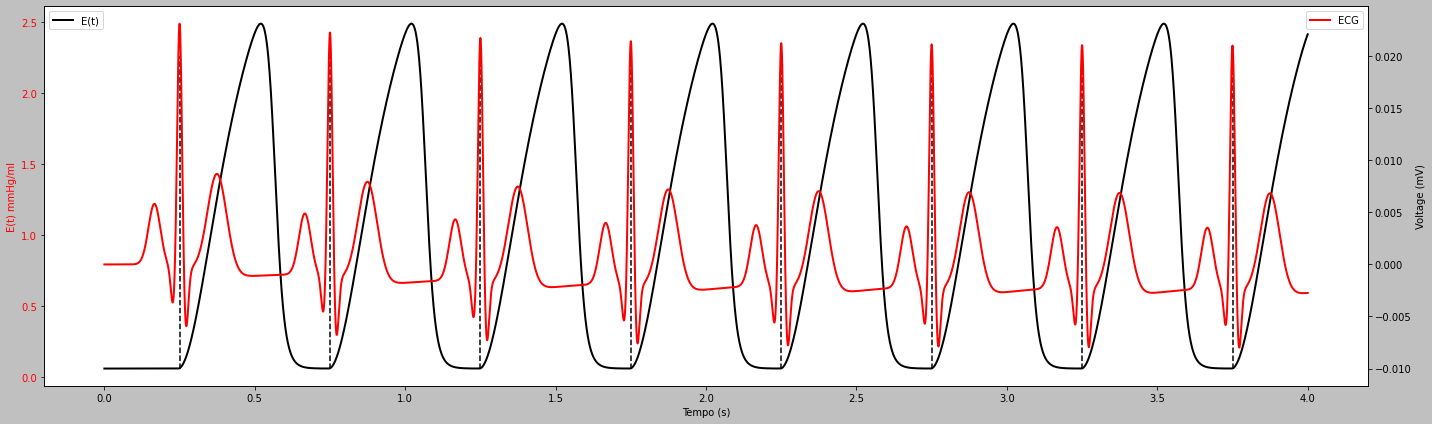

In [ ]:
ti = 0
HR = 120
passo = 0.0001
tf = 4
t = []

for i in np.arange(ti, tf, passo):
    t.append(i)

ECG, En = ECG_Gen(t, HR)

Emax = 2.5
Emin = 0.06
E = (Emax - Emin)*np.array(En) + Emin

ECG_Plot(t, E, ECG)

# Plot curvas com variáveis hemodinâmicas

In [ ]:
n = len(t)

# Parâmetros fornecidos pelo artigo Simaan

Rs  = 1.0000 # Systemic Vascular Resistance (SVR)
Rm  = 0.0050 # Mitral Valve Resistance
Cae = 4.4000 # Left Atrial Compliance
Ra  = 0.0010 # Aortic Valve Resistance
Rc  = 0.0398 # Characteristic Resistance
Cs  = 1.3300 # Systemic Compliance
Cao = 0.0800 # Aortic Compliance
Ls  = 0.0005 # Inertance of blood in Aorta

Vo = 10 # Pressão Inicial

Pao = np.zeros_like(t)
Qa  = np.zeros_like(t)
Vve = np.zeros_like(t)
Pas = np.zeros_like(t)
Pae = np.zeros_like(t)
Pve = np.zeros_like(t)

# Condições Iniciais
Pao[0] = 90
Qa[0]  = 0
Vve[0] = 140 
Pas[0] = 90
Pae[0] = 5

Pve[0] = E[0]* (Vve[0] - Vo) 

x = np.transpose([Pao[0], Qa[0], Vve[0], Pas[0], Pae[0]])

Dm = 0
Da = 0

In [ ]:
for i in range(n-1):
  Dm = 1 if Pae[i] >= Pve[i] else 0
  Da = 1 if Pve[i] >= Pao[i] else 0
 
  A = [[0], [0], [0], [0], [0]]
  A[0] = [-((Da)/(Ra)), -1, (Da)/(Ra) * (En[i]), 0, 0]/np.array(Cao)
  A[1] = [1, -(Rc), 0, -1, 0]/np.array(Ls)
  A[2] = [(Da)/(Ra), 0, -(((Dm)/(Rm)) + ((Da)/(Ra)))*En[i], 0, (Dm)/(Rm)]
  A[3] = [0, 1, 0, -1/(Rs), 1/(Rs)]/np.array(Cs)
  A[4] = [0, 0, (Dm)/(Rm) * En[i], 1/(Rs), -((1/(Rs))+((Dm)/(Rm)))]/np.array(Cae)
  
  B = [-(((Da)/(Ra))*En[i]*Vo)/Cao,
        0,
        ((Dm)/(Rm) + (Da)/(Ra))*En[i]*Vo,
        0,
        ( -((Dm)/(Rm))*En[i]*Vo)/Cae]

  xdot = np.dot(A, x) + B
  kx1 = passo*xdot

  x1 = x + 0.5*kx1
  xdot = np.dot(A, x1) + B
  kx2 = passo*xdot
  
  x1 = x + 0.5*kx2
  xdot = np.dot(A, x1) + B
  kx3 = passo*xdot

  x1 = x + kx3
  xdot = np.dot(A, x1) + B
  kx4 = passo*xdot

  x = x + (kx1 + 2*kx2 + 2*kx3 + kx4)/6
  
  Pao[i+1] =  x[0]
  Qa[i+1]  =  x[1]
  Vve[i+1] =  x[2]
  Pas[i+1] =  x[3]
  Pae[i+1] =  x[4]
  Pve[i+1] = En[i+1] * (Vve[i+1] - Vo)

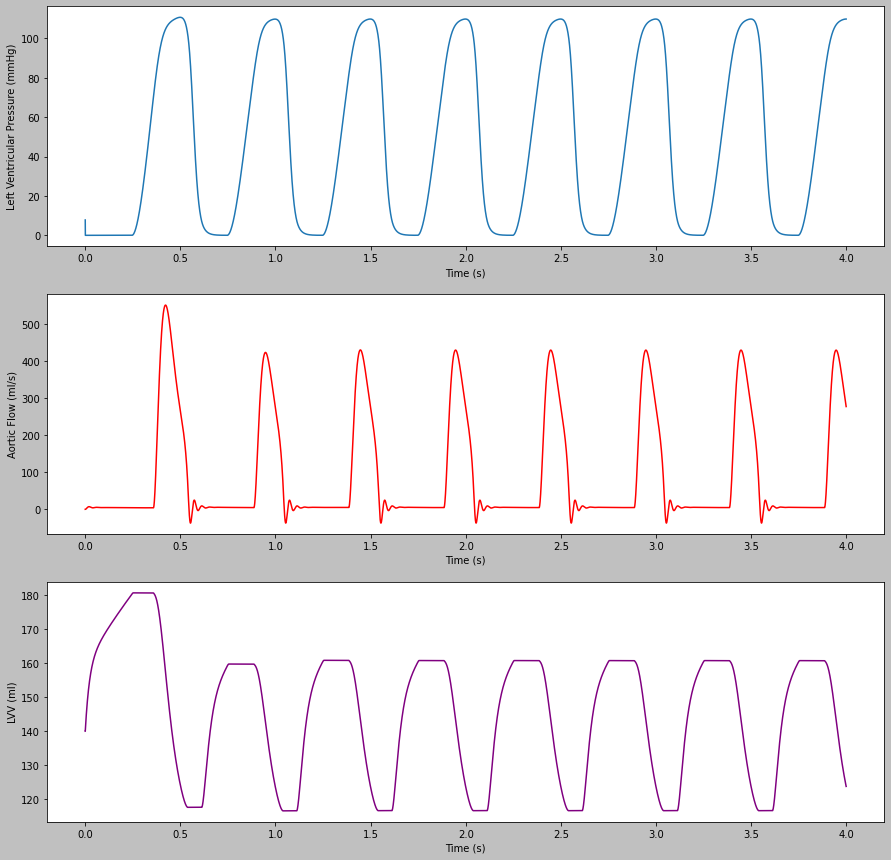

In [ ]:
plt.figure(figsize=(15,15), facecolor="silver")
plt.subplot(3,1,1)
plt.plot(t, Pve) # pressao ventriculo esquerdo
plt.ylabel("Left Ventricular Pressure (mmHg)")
plt.xlabel("Time (s)")

plt.subplot(3,1,2)
plt.plot(t, Qa, color="red") # Fluxo na aorta
plt.ylabel("Aortic Flow (ml/s)")
plt.xlabel("Time (s)")

plt.subplot(3,1,3)
plt.plot(t, Vve, color="purple") # volume ventriculo esquerdo
plt.ylabel("LVV (ml)")
plt.xlabel("Time (s)")

plt.show()

A partir dos gráficos acima, podemos concluir que as curvas continuam similares ao Simaan et al. <sup>[1]</sup> mesmo com o modelo sintético proposto por McSharry et al.<sup>[2]</sup>.

# Referências


<sup>[1]</sup> Simaan MA, Ferreira A, Chen S, Antaki JF, Galati DG. A dynamical state space
representation and performance analysis of a feedback-controlled rotary left
ventricular assist device. IEEE Transactions on Control Systems Technology. 2008
Dec 22;17(1):15-28.

<sup>[2]</sup> McSharry PE, Clifford GD, Tarassenko L, Smith LA. A dynamical model for genera-
ting synthetic electrocardiogram signals. IEEE transactions on biomedical engineering.

2003 Mar 20;50(3):289-94.